# Chapter 21. Network Analysis

In [183]:
from __future__ import division
import math, random, re
from collections import defaultdict, Counter, deque
from linear_algebra import dot, get_row, get_column, make_matrix, magnitude, scalar_multiply, shape, distance
from functools import partial

Many interesting data problems can be thought of in terms of [networks](https://en.wikipedia.org/wiki/Network_theory) consisting of nodes of some type and the edges that join them (see [graphs](https://en.wikipedia.org/wiki/Graph_%28discrete_mathematics%29) and [graph theory](https://en.wikipedia.org/wiki/Graph_theory) for more information on nodes and edges).  
For example, your Facebook friends form the nodes of a network whose edges are friendship relations.  
A less obvious example is the World Wide Web itself, with each web page a node, and each hyperlink from one page to another an edge.  
Facebook friendship is mutual -- if I am Facebook friends with you then necessarily you are friends with me.  
In this case, we say that the edges are [undirected](https://en.wikipedia.org/wiki/Graph_%28discrete_mathematics%29#Undirected_graph).  
Hyperlinks are not -- a website $A$ may link to website $Z$ without $Z$ linking to $A$.  
We call these types of edges [directed](https://en.wikipedia.org/wiki/Graph_%28discrete_mathematics%29#Directed_graph).  
We'll be dealing with both kinds of networks.

## Betweenness Centrality

In Chapter 1, we calculated the key connectors in the DataSciencester network by counting the number of friends that each user had.  
Now we have enough machinery to look at other approaches.  
Recall that the network comprised users:

In [184]:
users = [
    { "id": 0, "name": "Hero" },
    { "id": 1, "name": "Dunn" },
    { "id": 2, "name": "Sue" },
    { "id": 3, "name": "Chi" },
    { "id": 4, "name": "Thor" },
    { "id": 5, "name": "Clive" },
    { "id": 6, "name": "Hicks" },
    { "id": 7, "name": "Devin" },
    { "id": 8, "name": "Kate" },
    { "id": 9, "name": "Klein" }
]

and friendships:

In [185]:
friendships = [(0, 1), (0, 2), (1, 2), (1, 3), (2, 3), (3, 4),
               (4, 5), (5, 6), (5, 7), (6, 8), (7, 8), (8, 9)]

This is what our network looks like:

![users_network_graph](img/users_network_graph.png)

We also added friend lists to each user `dict`:

In [186]:
for user in users:
    user["friends"] = []
    
for i, j in friendships:
    # this works because users[i] is the user whose id is i 
    users[i]["friends"].append(users[j])  # add i as a friend of j
    users[j]["friends"].append(users[i])  # add j as a friend of i

When we left off we were dissatisfied with our notion of [degree centrality](https://en.wikipedia.org/wiki/Centrality#Degree_centrality), which didn't really agree with our intuition about who were the key connectors of the network.  
An alternative metric is [betweenness centrality](https://en.wikipedia.org/wiki/Centrality#Betweenness_centrality), which identifies people who frequently are on the shortest paths between pairs of other people.  
In particular, the betweenness centrality of node $i$ is computed by adding up, for every other pair of nodes $j$ and $k$, the proportion of shortest paths between node $j$ and node $k$ that pass through $i$.

As an example, to figure out Thor's betweenness centrality, we'll need to compute all of the shortest paths between all pairs of people who aren't Thor.  
Then we'll need to count how many of those shortest paths pass through Thor.  
For instance, the only shortest path between Chi (id 3) and Clive (id 5) passes through Thor, while neither of the shortest paths between Hero (id 0) and Chi (id 3) does.
Therefore, as a first step, we'll need to figure out the shortest paths between all pairs of people.  
There are some pretty sophisticated algorithms for doing so efficiently, but, because we're learning and building from scratch, we'll use a less efficient but more easily understood algorithm.

This algorithm, which is an implementation of [breadth-first search](https://en.wikipedia.org/wiki/Breadth-first_search), is one of the more complicated ones in this book, so let's go through it carefully:
1. Our goal is a function that takes a `from_user` and finds *all* shortest paths to every other user.
2. We'll represent a path as a `list` of user IDs. Since every path starts at `from_user`, we won't include her ID in the list. This means that the length of the list representing the path will be the length of the path itself.
3. We'll maintain a dictionary `shortest_paths_to` where the keys are user IDs and the values are lists of paths that end at the user with the specified ID. If there is a unique shortest path, the list will just contain that one path. If there are multiple shortest paths, the list will contain all of them.
4. We'll also maintain a [queue](https://en.wikipedia.org/wiki/Breadth-first_search) `frontier` that contains the users we want to explore in the order we want to explore them. (A queue is a data structure that is optimized for operations that "add to the end" and "remove from the front". In Python, they are implemented as [collections.deque](https://docs.python.org/2/library/collections.html#collections.deque) which is actually a double-ended queue.) We'll store them as pairs (`prev_user, user`) so that we know how we got to each one. We initialize the queue with all of the neighbors of `from_user`.
5. As we explore the graph, whenever we find new neighbors that we don't already know the shortest paths to, we add them to the end of the queue to explore later, with the current user as `prev_user`.
6. When we take a user off of the queue, and we've never encountered that user before, we've definitely found one or more shortest paths to him -- each of the shortest paths to `prev_user` with one extra step added.
7. When we take a user off of the queue and we *have* encountered that user before, then either we've found another shortest path (in which case we should add it) or we've found a longer path (in which case we shouldn't).
8. When no more users are left on the queue, we've explored the whole graph (or, at least. the parts of it that are reachable from the starting user) and we're done.

We can put all of this together into one, rather large, function:

In [187]:
def shortest_paths_from(from_user):
    
    # a dictionary from "user_id" to *all* shortest paths to that user
    shortest_paths_to = { from_user["id"] : [[]] }

    # a queue of (previous user, next user) that we need to check.
    # starts out with all pairs (from_user, friend_of_from_user)
    frontier = deque((from_user, friend)
                     for friend in from_user["friends"])

    # keep going until we empty the queue
    while frontier: 

        prev_user, user = frontier.popleft() # take from the beginning
        user_id = user["id"]

        # the fact that we're pulling from our queue means that
        # necessarily we already know a shortest path to prev_user
        paths_to_prev = shortest_paths_to[prev_user["id"]]
        paths_via_prev = [path + [user_id] for path in paths_to_prev]
        
        # it's possible we already know a shortest path to here as well
        old_paths_to_here = shortest_paths_to.get(user_id, [])
        
        # what's the shortest path to here that we've seen so far?
        if old_paths_to_here:
            min_path_length = len(old_paths_to_here[0])
        else:
            min_path_length = float('inf')
                
        # any new paths to here that aren't too long
        new_paths_to_here = [path_via_prev
                             for path_via_prev in paths_via_prev
                             if len(path_via_prev) <= min_path_length
                             and path_via_prev not in old_paths_to_here]
        
        shortest_paths_to[user_id] = old_paths_to_here + new_paths_to_here
        
        # add new neighbors to the frontier
        frontier.extend((user, friend)
                        for friend in user["friends"]
                        if friend["id"] not in shortest_paths_to)

    return shortest_paths_to

Now we can store these `dicts` with each node:

In [188]:
for user in users:
    user["shortest_paths"] = shortest_paths_from(user)

Now we're finally ready to calculate betweenness centrality.  
For every pair of nodes $i$ and $j$, we know the $n$ shortest paths from $i$ to $j$.  
Then, for each of those paths, we just add $1/n$ to the centrality of each node on that path:

In [189]:
for user in users:
    user["betweenness_centrality"] = 0.0
    
for source in users:
    source_id = source["id"]
    for target_id, paths in source["shortest_paths"].iteritems():
        if source_id < target_id:    # don't double count
            num_paths = len(paths)   # how many shortest_paths?
            contrib = 1 / num_paths  # contribution to centrality
            for path in paths:
                for id in path:
                    if id not in [source_id, target_id]:
                        users[id]["betweenness_centrality"] += contrib

for user in users:
    print user["id"], user["betweenness_centrality"]

0 0.0
1 3.5
2 3.5
3 18.0
4 20.0
5 20.5
6 6.0
7 6.0
8 8.5
9 0.0


The author included a nice visualization to show the relationships:

![betweenness_centrality](img/betweenness_centrality.png)

As shown above, users 0 and 9 have centrality 0.0 (meaning that neither one is on any shortest path between other users), whereas users 3, 4, and 5 all have high centralities (meaning that all three lie on many shortest paths).  
Generally the centrality numbers are relative and aren't that meaningful themselves; what we care about is how the numbers for each node compare to the numbers for other nodes.

## Closeness Centrality

Another measure that we can look at is [closeness centrality](https://en.wikipedia.org/wiki/Centrality#Closeness_centrality).  
First, for each user we calculate her [farness](http://www.analytictech.com/ucinet/help/oeky47.htm), which is the sum of the lengths of her shortest paths to each other user.  
Since we've already computed the shortest paths between each pair of nodes, we can add up their lengths.  
If there are multiple shortest paths, they all have the same length, so we can just look at the first one.

In [190]:
def farness(user):
    """ the sum of the lengths of the shortest paths to each other user """
    return sum(len(paths[0]) for paths in user["shortest_paths"].values())

Now we can go on and calculate closeness centrality as follows:

In [191]:
for user in users:
    user["closeness_centrality"] = 1 / farness(user)
    print user["id"], user["closeness_centrality"]

0 0.0294117647059
1 0.037037037037
2 0.037037037037
3 0.0454545454545
4 0.05
5 0.05
6 0.0416666666667
7 0.0416666666667
8 0.0357142857143
9 0.0277777777778


Now here's another pretty picture courtesy of the author to complement our results:

![closeness_centrality](img/closeness_centrality.png)

There is much less variation here -- even the very central nodes are still pretty far from the out on the periphery.  
Calculating shortest paths can be a bit of a challenge, which is one reason why betweenness and closeness centrality aren't often used on large networks.  
The less intuitive (but generally easier to compute) eigenvector centrality is more frequently used.

## Eigenvector Centrality

Time for some math.  
In order to talk about [eigenvector centrality](https://en.wikipedia.org/wiki/Eigenvector_centrality), we have to talk about [eigenvectors](https://en.wikipedia.org/wiki/Eigenvalues_and_eigenvectors), and in order to talk about eigenvectors, we have to talk about [matrix multiplication](https://en.wikipedia.org/wiki/Matrix_multiplication).  
If you need more information, [Khan Academy](https://www.khanacademy.org/) has lessons on ['Eigen-Everything'](https://www.khanacademy.org/math/linear-algebra/alternate-bases/eigen-everything/v/linear-algebra-introduction-to-eigenvalues-and-eigenvectors) and [Matrix Multiplication](https://www.khanacademy.org/math/linear-algebra/matrix-transformations/composition-of-transformations/v/compositions-of-linear-transformations-1) specifically, and [Linear Algebra](https://www.khanacademy.org/math/linear-algebra) in general.

### Matrix Multiplication

If $A$ is a $n_1 \times k_1$ matrix and $B$ is a $n_2 \times k_2$ matrix, and if $k_1 = n_2$, then their product $AB$ is the $n_1 \times k_2$ matrix whose $(i, j)th$ entry is:  

$\Large A_{i1}B_{1j} + A_{i2}B_{2j} + \ldots + A_{ik}B_{kj}$

which is just the `dot` product of the $i$th row of $A$ (thought of as a vector) with the $j$th column of $B$ (also thought of as a vector):

In [192]:
def matrix_product_entry(A, B, i, j):
    return dot(get_row(A, i), get_column(B, j))

This leads us to:

In [193]:
def matrix_multiply(A, B):
    n1, k1 = shape(A)
    n2, k2 = shape(B)
    if k1 != n2:
        raise ArithmeticError("Incompatible Matrix Shapes")
    
    return make_matrix(n1, k2, partial(matrix_product_entry, A, B))

Notice that if $A$ is a $n \times k$ matrix and B is a $k \times 1$ matrix, then $AB$ is a $n \times 1$ matrix.  
If we treat a vector as a one-column matrix, we can think of $A$ as a function that maps $k$-dimensional vectors to $n$-dimensional vectors, where the function is just matrix multiplication.  
Previously we represented vectors simply as lists, which isn't quite the same:

Now we'll need some helper functions to convert back and forth between the two representations:

In [194]:
def vector_as_matrix(v):
    """ returns a vector v (represented as a list) as a n x 1 matrix """
    return [[v_i] for v_i in v]

def vector_from_matrix(v_as_matrix):
    """ returns the n x 1 matrix as a list of values """
    return [row[0] for row in v_as_matrix]

after which we can define the matrix operation using `matrix_multiply`:

In [195]:
def matrix_operate(A, v):
    v_as_matrix = vector_as_matrix(v)
    product = matrix_multiply(A, v_as_matrix)
    return vector_from_matrix(product)

When $A$ is a *square* matrix, this operation maps $n$-dimensional vectors to other $n$-dimensional vectors.  
It's possible that, for some matrix $A$ and vector $v$, when $A$ operates on $v$ we get back a scalar multiple of $v$.  
That is, that the result is a vector that points in the same direction as $v$.  
When this happens (and when, in addition, $v$ is not a vector of all zeroes), we call $v$ an *eigenvector* of $A$ and we call the multiplier an *eigenvalue*.  


One possible way to find an eigenvector of $A$ is by picking a starting vector $v$, applying `matrix_operate`, rescaling the result to have magnitude 1, and repeating until the process converges:

In [196]:
def find_eigenvector(A, tolerance=0.00001):
    guess = [random.random() for __ in A]
    
    while True:
        result = matrix_operate(A, guess)
        length = magnitude(result)
        next_guess = scalar_multiply(1/length, result)
        
        if distance(guess, next_guess) < tolerance:
            return next_guess, length  # eigenvector, eigenvalue
        
        guess = next_guess

By construction, the returned `guess` is a vector such that, when you apply `matrix_operate` to it and rescale it to have length 1, you get back a vector that (almost) perfectly matches itself, which means it's an eigenvector.  
Not all matrices of real numbers have eigenvectors and eigenvalues.  
For example, the matrix:

rotates vectors 90 degrees clockwise, which means that the only vector it maps to a scalar multiple of itself is a vector of zeroes.  
If you tried `find_eigenvector(rotate)` it would run forever.  
Even matrices that have eigenvectors can sometimes get stuck in cycles.  
Conside the matrix:

This matrix maps any vector `[x, y]` to `[y, x]`.  
This means that, for example, `[1, 1]` is an eigenvector with eigenvalue 1.  
However, if you start with a random vector with unequal coordinates, `find_eigenvector` will just repeatedly swap the coordinates forever.  
Not-from-scratch libraries like NumPy use different methods that would work in this case.  
Nonetheless, when `find_eigenvector` does return a result, that result is indeed an eigenvector.

### Centrality

Neat stuff and all, BUT ... how does this help us understand the DataSciencester network?  
To start with, we'll need to represent the connections in our network as an [adjacency matrix](https://en.wikipedia.org/wiki/Adjacency_matrix), whose `(i, j)th` entry is either 1 (if user $i$ and user $j$ are friends) or 0 (if they'r not):

In [197]:
def entry_fn(i, j):
    return 1 if (i, j) in friendships or (j, i) in friendships else 0

n = len(users)
adjacency_matrix = make_matrix(n, n, entry_fn)

adjacency_matrix

[[0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 1, 1, 0, 0, 0, 0, 0, 0],
 [1, 1, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 1, 1, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 1, 1, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 1, 1, 0, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]]

The eigenvector centrality for each user is then the entry corresponding to that user in the eigenvector returned by `find_eigenvector`.  
For technical reasons that are way beyond the scope of this book, any nonzero adjacency matrix necessarily has an eigenvector all of whose values are non-negative.  
Fortunately for us, for this `adjacency_matrix` our `find_eigenvector` function finds it.

In [198]:
eigenvector_centralities, _ = find_eigenvector(adjacency_matrix)

eigenvector_centralities

[0.38578050237648764,
 0.5147907907246216,
 0.5147907907246216,
 0.4733122842376299,
 0.23360976485721197,
 0.1501439572590918,
 0.08355428177034407,
 0.08355428177034407,
 0.07283846222351022,
 0.02729398147349629]

Here's another visual aid courtesy of the author:

![eigenvector_centrality](img/eigenvector_centrality.png)

Users with high eigenvector centrality should be those who have a lot of connections as well as connections to people who themselves have high centrality.  
As shown above, users 1 and 2 are the most central, as they both have three connections to people who are themselves highly central.  
As we move away from them, people's centralities steadily drop off.

On a network this small, eigenvector centrality behaves somewhat erratically.  
If you try adding or subtracting links, you'll find that small changes in the network can dramatically change the centrality numbers.  
In a much larger network this would not be the case.  

We still haven't explained why an eigenvector might lead to a reasonable notion of centrality.  
Being an eigenvector means that if you calculate:

In [199]:
matrix_operate(adjacency_matrix, eigenvector_centralities)

[1.0295815814492433,
 1.3738835773387392,
 1.3738835773387392,
 1.2631913463064552,
 0.6234562414967217,
 0.4007183283979001,
 0.222982419482602,
 0.222982419482602,
 0.19440254501418444,
 0.07283846222351022]

the result is a [scalar multiple](http://www.mathnotes.org/?pid=87#?pid=87) of `eigenvector_centralities`.

If you look at how matrix multiplication works, `matrix_operate` produces a vector whose $i$th element is:

In [200]:
dot(get_row(adjacency_matrix, i), eigenvector_centralities)

0.19440254501418444

which is precisely the sum of the eigenvector centralities of the users connected to user $i$.

In other words, eigenvector centralities are numbers, one per user, such that each user's value is a constant multiple of the sum of her neighbors' values.  
In this case centrality means being connected to people who themselves are central.  
The more centrality you are directly connected to, the more central you are.  
This is, of course, a circular definition, and eigenvectors are the way of breaking out of the circularity.

Another way of understanding this is by thinking about what `find_eigenvector` is doing here.  
It starts by assigning each node a random centrality.  
It then repeats the following two steps until the process converges on a result:  
1. Give each node a new centrality score that equals the sum of its neighbors' (old) centrality scores.
2. Rescale the vector of centralities to have magnitude 1.  

Althought the math behind this method may seem somewhat opaque at first, the calculation itself is relatively straighforward (compared to betweenness centrality, anyway) and is fairly simple to perform on even very large graphs.

## Directed Graphs and PageRank

DataSciencester isn't getting much traction, so the VP of Revenue considers pivoting from a friendship model to an endorsement model.  
It turns out that no one really cares which data scientists are *friends* with one another, but tech recruiters care very much which data scientists are respected by other data scientists.  
In this new model, we'll track endorsements `(source, target)` that no longer represent a reciprocal relationship, but rather that `source` endorses `target` as an awesome data scientist:

![network_of_endorsements](img/network_of_endorsements.png)

We'll first need to account for this asymmetry:

In [201]:
endorsements = [(0, 1), (1, 0), (0, 2), (2, 0), (1, 2),
                (2, 1), (1, 3), (2, 3), (3, 4), (5, 4),
                (5, 6), (7, 5), (6, 8), (8, 7), (8, 9)]

for user in users:
    user["endorses"] = []     # add one list to track outgoing endorsements 
    user["endorsed_by"] = []  # and another to track endorsements
    
for source_id, target_id in endorsements:
    users[source_id]["endorses"].append(users[target_id])
    users[target_id]["endorsed_by"].append(users[target_id])

after which we can find the `most_endorsed` data scientists and sell that information to recruiters:

In [202]:
endorsements_by_id = [(user["id"], 
                       len(user["endorsed_by"])) 
                       for user in users]

sorted(endorsements_by_id, key=lambda (user_id, num_endorsements): num_endorsements, reverse=True)

[(0, 2),
 (1, 2),
 (2, 2),
 (3, 2),
 (4, 2),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1)]

Keep in mind that 'number of endorsements' is an easy metric to game.  
All someone needs to do to manipulate the rankings is create fake accounts and have them endorse someone, or arrange with your friends to endorse each other (as users 0, 1, and 2 appear to have done).  
A better metric would be to take into account *who* endorses you.  
Endorsements from people who have a lot of endorsements themselves should (somehow) carry more weight than endorsements from people who only have a few of them.  
This is the essence of the [PageRank algorithm](https://en.wikipedia.org/wiki/PageRank) (with more information [here](http://www.cse.unt.edu/~tarau/teaching/NLP/PageRank.pdf)), which is used by Google to rank websites based on which other websites link to them, which other websites link to those, and so on.  
If this reminds you of the idea behind eigenvector centrality, it should.

Our simplified version of PageRank works like this:
1. There is a total of 1.0 (or 100%) PageRank in the network.
2. Initially this PageRank is equally distributed among nodes.
3. At each step, a large fraction of each node's PageRank is distributed evenly among its outgoing links.
4. At each step, the remainder of each node's PageRank is distributed evenly among all nodes.

In [203]:
def page_rank(users, damping=0.85, num_iters=100):
    
    # initially distribute PageRank evenly 
    num_users = len(users)
    pr = { user["id"] : 1 / num_users for user in users }
    
    # this is the small fraction of PageRank that each node gets in each iteration
    base_pr = (1 - damping) / num_users
    
    for __ in range(num_iters):
        next_pr = { user["id"] : base_pr for user in users }
        for user in users:
            # distribute PageRank to outgoing links
            links_pr = pr[user["id"]] * damping
            for endorsee in user["endorses"]:
                next_pr[endorsee["id"]] += links_pr / len(user["endorses"])
        pr = next_pr
                
    return pr

page_rank(users, damping=0.85, num_iters=100)

{0: 0.0404553415061296,
 1: 0.044921190893169885,
 2: 0.044921190893169885,
 3: 0.0404553415061296,
 4: 0.06785083675770529,
 5: 0.04344422700587085,
 6: 0.03346379647749512,
 7: 0.03346379647749512,
 8: 0.04344422700587085,
 9: 0.03346379647749512}

According to our version of PageRank, user 4 (Thor) is the highest ranked data scientist.  
Again with the visualizations:

![page_rank](img/page_rank.png)

Even though Thor has fewer endorsements (2) than users 0, 1, and 2, his endorsements carry with them the weight of rank from their other endorsements.  
Furthermore, both of Thor's endorsers endorsed *only* him, which means that he doesn't have to divide their rank with anyone else.

## For Further Exploration

- We examined a few of the most popular notions of centrality, but there [are many more](https://en.wikipedia.org/wiki/Centrality).
- [Gephi](https://gephi.org/) is a GUI-based network visualization tool.
- [NetworkX](https://networkx.github.io/) is a Python library for network analysis that has functions for computing centralities and for visualizing graphs. Below is a some code from the [examples](https://networkx.readthedocs.io/en/stable/examples/index.html) that [computes eigenvalues](https://networkx.readthedocs.io/en/stable/examples/advanced/eigenvalues.html).

('Largest eigenvalue:', 1.5995839377301895)
('Smallest eigenvalue:', 5.1987656708542984e-16)


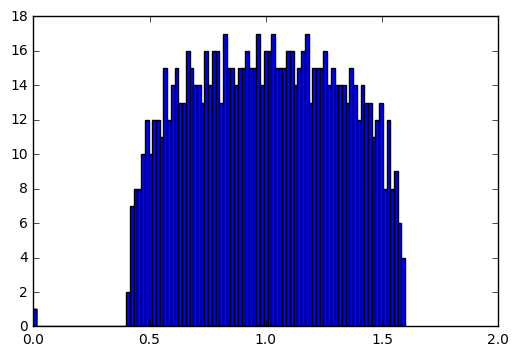

In [204]:
"""
Create an G{n,m} random graph and compute the eigenvalues.
Requires numpy and matplotlib.
"""
import networkx as nx
import numpy.linalg
import matplotlib.pyplot as plt

n = 1000 # 1000 nodes
m = 5000 # 5000 edges
G = nx.gnm_random_graph(n,m)

L = nx.normalized_laplacian_matrix(G)
e = numpy.linalg.eigvals(L.A)
print("Largest eigenvalue:", max(e))
print("Smallest eigenvalue:", min(e))
plt.hist(e,bins=100) # histogram with 100 bins
plt.xlim(0,2)  # eigenvalues between 0 and 2
plt.show()